In [3]:
from datetime import date
# tratamiento de los datos
# ============================================
import pandas as pd
import numpy as np
import sidetable
# librerías para la visualización de los datos
# ============================================
import matplotlib.pyplot as plt
import seaborn as sns

# Establecer tamaño fijo de gráficas
# ==================================
plt.rcParams["figure.figsize"] = (10,8)
# Librerias para los modelos
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
# Barra de progreso de un proceso
# ------------------------------------------------------------------------------
from tqdm import tqdm
# Configuración warnings
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns=None


In [4]:
df = pd.read_csv("datos/bikes_estandarizado.csv", index_col=0)
df.head(2)

,season,year,month,holiday,weeakday,weathersit,sensation,humidity,windspeed,casual,registered,count
0,winter,0,1,1,1,2,-0.456399,0.855582,-0.208909,-0.494713,-1.319816,985
1,winter,0,1,0,2,2,-0.492863,0.332722,0.687550,-0.751041,-1.312801,801


# Encoding

Vamos a proceder a realizar el encoding de acuerdo a lo visto en el análisis exploratorio.

In [5]:
df.reset_index(drop=True, inplace=True)

## le daremos los números más altos a aquellas categorías que sean más importantes, en este caso, al clima bueno
mapa = {3:1,2:2,1:3} 
df["weathersit_map"] = df["weathersit"].map(mapa)

# Columna año
mapa_año={0:1,1:2}
df["year_map"] = df["year"].map(mapa_año)

#Columna season
mapa_season={"winter":1,"autumn":2,"spring":3,"summer":3}
df["season_map"] = df["season"].map(mapa_season)

#columna day
mapa_dia={1:1, 2:2, 3:1, 4:1, 5:2, 6:1, 7:2}
df["weeakday_map"] = df["weeakday"].map(mapa_dia)

Vamos a eliminar las columnas que no vamos a ocupar para nuestro modelo.
Nota: 
Se hicieron pruebas con las diversas columnas, en diferentes combinaciones y nos quedamos con las que afectaban de manera más significativa a nuestra variable así como las que nos dieron los mejores resultados.

In [6]:
df.drop(["season","weeakday","month","registered","holiday","weathersit","weeakday_map","humidity","casual","year"], axis=1, inplace=True)
df.head(2)

,sensation,windspeed,count,weathersit_map,year_map,season_map
0,-0.456399,-0.208909,985,2,1,1
1,-0.492863,0.687550,801,2,1,1


## 🌳🌳 DECISION TREE 🌳🌳

Vamos a proceder a realizar el módelo.

In [7]:
# al igual que en la regresión lineal tenemos que separar nuestro dataframe en X e y
X = df.drop(["count"], axis = 1)
y = df["count"]
# y dividir nuestros datos en train y test para poder evaluar la bondad de nuestro modelo
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# creamos el objeto del modelo, al igual que hacíamos en la regresión lineal
arbol = DecisionTreeRegressor(random_state =0)

# ajustamos el modelo, igual que en la regresión lienal. 
arbol.fit(x_train, y_train)

DecisionTreeRegressor(random_state=0)

In [8]:
# max features. Como vemos, debemos poner en nuestro modelo una profudidad máxima de 3.
max_features = np.sqrt(len(x_train.columns))
max_features

2.23606797749979

In [9]:
# max depth
print(arbol.tree_.max_depth)

18


In [10]:
# hacemos las predicciones sobre los dos set de datos el X_test y el X_train
y_pred_test_dt = arbol.predict(x_test)
y_pred_train_dt = arbol.predict(x_train)

In [11]:
def metricas(y_test, y_train, y_test_pred, y_train_pred, tipo_modelo):
    
    
    resultados = {'MAE': [mean_absolute_error(y_test, y_test_pred), mean_absolute_error(y_train, y_train_pred)],
                'MSE': [mean_squared_error(y_test, y_test_pred), mean_squared_error(y_train, y_train_pred)],
                'RMSE': [np.sqrt(mean_squared_error(y_test, y_test_pred)), np.sqrt(mean_squared_error(y_train, y_train_pred))],
                'R2':  [r2_score(y_test, y_test_pred), r2_score(y_train, y_train_pred)],
                 "set": ["test", "train"]}
    df = pd.DataFrame(resultados)
    df["modelo"] = tipo_modelo
    return df

In [12]:
# sacamos las métricas para ver si hay overfitting o unerfitting, para modificar la profundidad en función de estos resultados
dt_results1 = metricas(y_test, y_train, y_pred_test_dt, y_pred_train_dt, "Decission Tree I")
dt_results1

,MAE,MSE,RMSE,R2,set,modelo
0,670.575342,871277.136986,933.422272,0.745452,test,Decission Tree I
1,0.000000,0.000000,0.000000,1.000000,train,Decission Tree I


In [13]:
param = {"max_depth": [1,2,3,4,5,6,7,8,9],
        "max_features": [1,2,3,4],
        "min_samples_split": [20, 50, 100],
        "min_samples_leaf": [20, 50, 100]} 

gs = GridSearchCV(
            estimator=DecisionTreeRegressor(), 
            param_grid= param, 
            cv=10,  
            verbose=-1,
            return_train_score = True,
            scoring="neg_mean_squared_error") 

In [14]:
# ajustamos el modelo que acabamos de definir en el GridSearch
gs.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'max_features': [1, 2, 3, 4],
                         'min_samples_leaf': [20, 50, 100],
                         'min_samples_split': [20, 50, 100]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=-1)

In [15]:
mejor_modelo = gs.best_estimator_
mejor_modelo

DecisionTreeRegressor(max_depth=6, max_features=4, min_samples_leaf=20,
                      min_samples_split=20)

In [16]:
y_pred_test_dt2 = mejor_modelo.predict(x_test)
y_pred_train_dt2 = mejor_modelo.predict(x_train)

dt_results2 = metricas(y_test, y_train, y_pred_test_dt2, y_pred_train_dt2, "Decision tree II")
dt_results2

,MAE,MSE,RMSE,R2,set,modelo
0,606.425964,622369.480682,788.903974,0.818172,test,Decision tree II
1,610.987487,675753.051024,822.042001,0.822902,train,Decision tree II


In [17]:
# vamos  a juntar los dataframes de los resultados de los modelos para poder compararlos mejor

df_decision_results = pd.concat([dt_results1, dt_results2], axis = 0)
df_decision_results

,MAE,MSE,RMSE,R2,set,modelo
0,670.575342,871277.136986,933.422272,0.745452,test,Decission Tree I
1,0.000000,0.000000,0.000000,1.000000,train,Decission Tree I
0,606.425964,622369.480682,788.903974,0.818172,test,Decision tree II
1,610.987487,675753.051024,822.042001,0.822902,train,Decision tree II


Como podemos obbservar nuestras métricas no son para nada buenas, pero son las mejores que se han logrado conseguir. Vamos a realizar otro método llamado ramdom forest para ver si conseguimos mejores resultados.

In [18]:
# vamos a crearnos un dataframe 
importancia_predictores = pd.DataFrame(
                            {'predictor': x_train.columns,
                             'importancia': mejor_modelo.feature_importances_}
                            )
# ordenamos de mayor a menor los resultados
importancia_predictores.sort_values(by=["importancia"], ascending=False, inplace = True)
# printeamos los resultados
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores

Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
0,sensation,0.518485
3,year_map,0.324693
4,season_map,0.100970
2,weathersit_map,0.044743
1,windspeed,0.011109


En cuanto a la importancia de nuestras variables podemos ver que en mayor o menor medida relevancia para nuestra variable respuesta.

## 🌳🌲🌳🌱🌳 RANDOM FOREST 🌳🌲🌳🌱🌳

Vamos a probar ahora con el módelo Random Forest para ver si conseguimos mejores resultados.

In [19]:
Xs = df.drop(["count"], axis = 1)
ys = df["count"]

In [20]:
# y dividir nuestros datos en train y test para poder evaluar la bondad de nuestro modelo
x_train, x_test, y_train, y_test = train_test_split(Xs, ys, test_size = 0.2, random_state = 42)

param = {"max_depth": [1,2,3,4,5,6,7,8,9], 
        "max_features": [1,2,3],
        "min_samples_split": [20, 50, 100],
        "min_samples_leaf": [20, 50, 100]} 

gs_rf = GridSearchCV(
            estimator=RandomForestRegressor(), 
            param_grid= param, 
            cv=10, 
            verbose=-1, 
            return_train_score = True,
            scoring="neg_mean_squared_error")

# 🚨 Esta celda puede tardar en ejecutarse
gs_rf.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'max_features': [1, 2, 3],
                         'min_samples_leaf': [20, 50, 100],
                         'min_samples_split': [20, 50, 100]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=-1)

In [21]:
bosque = gs_rf.best_estimator_
bosque

RandomForestRegressor(max_depth=8, max_features=3, min_samples_leaf=20,
                      min_samples_split=20)

In [22]:
y_pred_test_rf = bosque.predict(x_test)
y_pred_train_rf = bosque.predict(x_train)

In [23]:
def metricas(y_test, y_train, y_test_pred, y_train_pred, tipo_modelo):
    
    
    resultados = {'MAE': [mean_absolute_error(y_test, y_test_pred), mean_absolute_error(y_train, y_train_pred)],
                'MSE': [mean_squared_error(y_test, y_test_pred), mean_squared_error(y_train, y_train_pred)],
                'RMSE': [np.sqrt(mean_squared_error(y_test, y_test_pred)), np.sqrt(mean_squared_error(y_train, y_train_pred))],
                'R2':  [r2_score(y_test, y_test_pred), r2_score(y_train, y_train_pred)],
                 "set": ["test", "train"]}
    df = pd.DataFrame(resultados)
    df["modelo"] = tipo_modelo
    return df

In [24]:
# sacamos las métricas para ver si hay overfitting o unerfitting, para modificar la profundidad en función de estos resultados

dt_results = metricas(y_test, y_train, y_pred_test_rf, y_pred_train_rf, "Random Forest")
dt_results

,MAE,MSE,RMSE,R2,set,modelo
0,590.034402,566064.302725,752.372449,0.834622,test,Random Forest
1,613.944466,687629.027380,829.234000,0.819789,train,Random Forest


Bueno tenemos mejores métricas pero todavía son muy altas vamos a ver la importancia de nuestras variables.

In [25]:
importancia_predictores = pd.DataFrame(
                            {'predictor': x_train.columns,
                             'importancia': bosque.feature_importances_}
                            )

# ordenamos de mayor a menor los resultados
importancia_predictores.sort_values(by=["importancia"], ascending=False, inplace = True)

# printeamos los resultados
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores

Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
0,sensation,0.443212
3,year_map,0.329921
4,season_map,0.177090
2,weathersit_map,0.032191
1,windspeed,0.017587


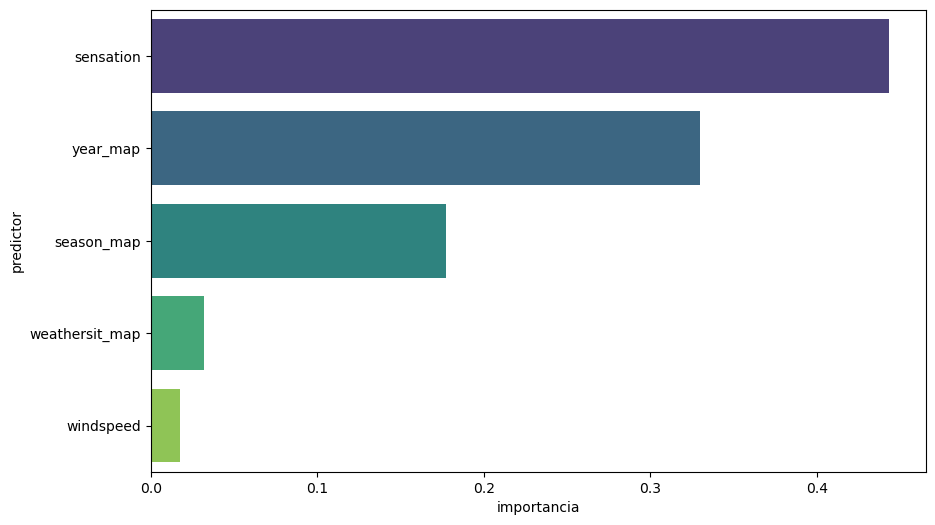

In [26]:
# por último ploteamos los resultados para verlo de una forma más amigable. 

plt.figure(figsize=(10,6))
sns.barplot(x = "importancia", y = "predictor", data = importancia_predictores, palette="viridis");
plt.show()

Como podemos ver la variable Sensacion termica es que la que tiene más relevancia lo cual tiene sentido ya que el clima y la temperatura jugarán un papel fundamental para que un cliente ya sea casual o registrado decida coger una bicicleta o no.

Como nuestros resultados no son los esperados hemos decidido hacer más pruebas con más modelos cambiando la variable respuesta y las variables predictoras. Lo veremos en los siguientes jupyters.